<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="1000px"/>

# NIRSpec MOS data reprocessing with the JWST pipeline

Updated February 2024 running JWST pipeline version 1.13.4 with CRDS context jwst_1193.pmap

processing data from JWST CAL program 1128

## Table of Contents

* [Overview](#overview)
* [Observations](#observations)
* [JWST Pipeline](#pipeline)
* [Related Notebooks](#related)
* [Import Libraries](#import)
* [Download the data](#data)
* [Stage1: `Detector1Pipeline`](#stage1)
* [Stage2: `Spec2Pipeline`](#stage2)
* [Stage3: `Spec3Pipeline`](#stage3)
* [Change 1D extraction rows: `Extract1dStep`](#extract1d)

# Wish List

* distinguish confirmation images vs. science in MAST (current hack is to download smaller files with fewer groups)
* automatic way to determine file to download from CRDS: 'jwst_nirspec_extract1d_0003.json'
* why is that one quadrant so high in the one rate file?

# Overview <a id='overview'></a>

Data from JWST observations are processed by the JWST pipeline and made available in MAST.
Outputs from any stage of the pipeline may be retrieved and reprocessed if desired.

There are some 
[known issues with NIRSpec MOS data products](https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/known-issues-with-jwst-data-products)
and with the 
[JWST pipeline run on NIRSpec MOS data](https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats)
using default settings.

When rerunning the pipeline on this NIRSpec MOS data, we make two key adjustments to input parameters:
* outlier rejection of cosmic rays and snowballs: `Detector1Pipeline` jump step 
* extraction rows for 1D spectrum (`x1d`) from 2D spectrum (`s2d`): `extract1d` [`ystart` – `ystop`]

# JWST Science Calibration Pipeline <a id='pipeline'></a>
**JWST Pipeline**
[JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview) • 
[ReadtheDocs](https://jwst-pipeline.readthedocs.io) • 
[Github](https://github.com/spacetelescope/jwst) •
`pip install jwst`

Below we summarize the various pipeline stages and data products.

[**Data Products**](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html)
(also see [JDox](https://jwst-docs.stsci.edu/getting-started-with-jwst-data/understanding-jwst-data-files/jwst-data-products))  

`uncal` (counts) –> `rate` (slopes) –> `cal` (extracted calibrated 2D spectra) –> `s2d` (rectified 2D spectra) –> `x1d` (1D spectra)

[Retrieve data from MAST](https://outerspace.stsci.edu/display/MASTDOCS/API+Advanced+Search)
(also see [ReadtheDocs](https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html))

`uncal` uncalibrated data saved from every detector readout

[**JWST Pipeline Stages**](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing)
(also see [ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/main.html))

[**Stage 1**](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1):
[calwebb_detector1](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html)
[`Detector1Pipeline`](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pipeline.Detector1Pipeline.html)

Detector corrections for flat field, artifacts, etc., followed by ramp fitting to slopes (count rates)  
`rate` count rate (slope) averaged over multiple integrations, if available  
`rateints` count rates for each individual integration (saved in multiple extensions)

[**Stage 2**](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec2):
[calwebb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)
[`Spec2Pipeline`](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pipeline.Spec2Pipeline.html)

Extracted calibrated spectra for each source from each exposure (or association) and each detector, including any corrections for slit loss, path loss, and bar shadows.
Slits or exposures defined as background will have negative spectra.
Each source will be an extension in the file:  
`cal` / `calints` calibrated 2D (unrectified) spectra (flux vs. wavelength)  
`crf` / `crfints` cosmic ray flagged data, identical to `cal` products with updated DQ arrays  
`s2d` 2D spectra resampled (rectified) to a rectangle  
`x1d` 1D spectra extracted from rows of 2D spectrum

[**Stage 3**](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec3):
[calwebb_spec3](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html)
[`Spec3Pipeline`](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pipeline.Spec3Pipeline.html)

Extracted calibrated spectra for each source:  
`cal` / `calints` identical to Stage 2 outputs, repackaged for each source (multiple extensions for each exposure and detector)  
`crf` / `crfints` cosmic ray flagged data, identical to `cal` products with updated DQ arrays  
spectra combined from multiple exposures, including background subtraction:
`s2d` 2D spectra resampled (rectified) to a rectangle  
`x1d` 1D spectra extracted from rows of 2D spectrum

Note these filenames will have the same extensions (`cal`, `s2d`, `x1d`, etc.) but have different structures depending on which stage they are output from:
* Stage 2: one file from each exposure (or association) and detector; one extension for each source
* Stage 3: one file for each source; `cal`: one extension for each exposure (or association) and detector

# Related Notebooks <a id='related'></a>


* [NIRSpec MOS pipeline caveats](https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats)
and workaround notebooks for 
[general NIRSpec](https://github.com/spacetelescope/jwst-caveat-examples/tree/main/NIRSPEC_General)
data and
[NIRSpec MOS](https://github.com/spacetelescope/jwst-caveat-examples/tree/main/NIRSPEC_MOS)
* Notebooks running pipeline on [NIRSpec fixed slit data](coming soon) and
[BOTS data](https://github.com/exonik/JWebbinar2023-TSO)
* Notebooks running pipeline on simulated NIRSpec MOS data:
[JWebbinar7 (Oct 2021)](https://github.com/spacetelescope/jwebbinar_prep/blob/webbinar7/mos_session/jwebbinar7_nirspecmos.ipynb) •
[JDAT (2021)](https://github.com/spacetelescope/dat_pyinthesky/blob/main/jdat_notebooks/mos-spectroscopy/MOSspec_sv06_revised.ipynb) •
[JADES (June 2022)](https://github.com/eclake/NIRSpec_GTO_sims_STScI_reduction/blob/master/NIRSpec%20GTO%20IPS%20Simultions.ipynb)
* [Notebook processing ERO SMACS0723 NIRSpec MOS data](https://github.com/gbrammer/msaexp/blob/main/docs/examples/process-smacs0723.ipynb)
using the JWST pipeline and 
[msaexp](https://github.com/gbrammer/msaexp)
* [MOSViz notebook analyzing NIRSpec MOS spectra](https://spacetelescope.github.io/jdat_notebooks/notebooks/mos_spectroscopy_advanced/MOSspec_advanced.html)
* [JDAT: JWST Data Analysis Example Notebooks](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis/data-analysis-example-jupyter-notebooks)

### JWST file naming conventions

https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

# Import Libraries <a id='import'></a>

In [1]:
import os
home = os.path.expanduser("~")
from glob import glob
import numpy as np
from astropy.io import fits

In [2]:
# Define CRDS paths *before* importing jwst pipeline
# otherwise you'll get FileNotFoundError: [Errno 2] : No such file or directory: '$HOME/crds_cache/config/jwst/server_config'

#os.environ["CRDS_PATH"] = "$HOME/crds_cache"
#os.environ["CRDS_PATH"] = '/grp/crds/cache/' at STScI
os.environ["CRDS_PATH"] = os.path.join(home, "crds_cache")
os.makedirs(os.environ['CRDS_PATH'], exist_ok=True)

os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
print(os.environ['CRDS_PATH'])

import crds
print("Current Operational CRDS Context = {}".format(crds.get_default_context()))

/Users/dcoe/crds_cache
Current Operational CRDS Context = jwst_1193.pmap


In [3]:
# Import JWST pipeline 

import jwst
from jwst import datamodels
from jwst.pipeline import Detector1Pipeline   # calwebb_detector1
from jwst.pipeline import Spec2Pipeline       # calwebb_spec2
from jwst.pipeline import Spec3Pipeline       # calwebb_spec3
from jwst.extract_1d import Extract1dStep     # Extract1D Individual Step
from jwst.associations import asn_from_list   # create association file
import json

# JWST version won't be right if development version (may say 1.12.3 when it's really 1.12.6)
print("JWST Calibration Pipeline Version={}".format(jwst.__version__)) 

JWST Calibration Pipeline Version=1.13.4


In [4]:
from IPython.display import JSON  # nicer interactive output of JSON dictionaries

In [5]:
# To run faster on multiple cores in parallel
import multiprocessing as mp 
print("Number of processors: ", mp.cpu_count())

Number of processors:  10


In [6]:
# To retrieve data from MAST

import astroquery
print('astroquery version', astroquery.__version__)
from astroquery.mast import Observations, Mast

from astropy.table import Table, vstack, unique

astroquery version 0.4.6


In [7]:
# To view results

import matplotlib # as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})  # 18

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe # https://stackoverflow.com/questions/25426599/matplotlib-how-to-buffer-label-text

from astropy.visualization import simple_norm, ImageNormalize, AsinhStretch, ManualInterval, LogStretch, LinearStretch
from astropy.stats import sigma_clip, sigma_clipped_stats  # , SigmaClip

In [8]:
# Define colormap
cmap = 'viridis'
#bad_color = 1, 0.7, 0.7
bad_color = 'r'  # color used for nan values
cmap = matplotlib.colormaps[cmap]
cmap.set_bad(bad_color, 1.)

In [9]:
def between(lo, x, hi):
    return (lo <= x) * (x <= hi)

In [37]:
def print_dict(d, indent=0):
    #print()
    #print("=====")
    #print()
    for key in d.keys():
        #print()
        #print("----")
        #print()
        val = d[key]
        try:
            keys = val.keys()
            print(' ' * indent, key)
            #if type(val) == type({}):
            print_dict(val, indent+4)
            #print_dict(d, indent+4)
        except:
            if type(val) == type([]):
                for i, item in enumerate(val):
                    print(' ' * indent, '[%d]' % i)
                    print_dict(item, indent+4)
            else:
                print(' ' * indent, key, ':', d[key])

# Set up data directories

In [10]:
download_dir = 'data'  # download from MAST
os.makedirs(download_dir, exist_ok=True)

In [11]:
#rate_dir = 'com_mos_rate_files'  # Charles Proffitt  /grp/jwst/wit4/nirspec/proffitt/msa_fflat_sprint_files/com_mos_rate_files/
rate_dir = 'st_mos_rate_files'  # Melanie -- new pipeline run

In [12]:
output_dir = 'no-background-subtraction'  # '3slitlet_exptime' reprocess 3slitlet_3asn
os.makedirs(output_dir, exist_ok=True)

In [13]:
run_pipeline = True  # if False, already ran the pipeline; just load the results

# Download UNCAL files: Query and retrieve from MAST archive <a id='data'></a> 

https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data  

https://astroquery.readthedocs.io/en/latest/api/astroquery.mast.ObservationsClass.html  

https://outerspace.stsci.edu/display/MASTDOCS/API+Advanced+Search

https://mast.stsci.edu/api/v0/_productsfields.html

In [14]:
def download_jwst_files(filenames, download_dir, mast_dir='mast:jwst/product'):
    # Download data
    #manifest = Observations.download_products(chosen_obsIDs, download_dir=DOWNLOAD_DIR)  # , flat=True

    downloaded_files = []
    os.makedirs(download_dir, exist_ok=True)
    for filename in filenames:
        filename   = os.path.basename(filename)
        mast_path  = os.path.join(mast_dir,     filename)
        local_path = os.path.join(download_dir, filename)
        if os.path.exists(local_path):
            print(local_path, 'EXISTS')
        else:
            # Can let this command check if local file exists
            # However, it will delete it if it's there and the wrong size (e.g., reprocessed)
            Observations.download_file(mast_path,   local_path=local_path)
        downloaded_files.append(local_path)

    return downloaded_files

In [15]:
def allin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element not in list_or_string:
            return False
    return True

def anyin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element in list_or_string:
            return True
    return False

# Select subset of files containing all search strings
def select_files(all_files, search_strings=[]):
    chosen_files = [file for file in all_files if allin(search_strings, file)]
    if len(chosen_files) == 1:
        chosen_files = chosen_files[0]
    return chosen_files    

# Show rate file

In [16]:
def show_MOS_rate(rate_file, slits_model, save_plot=False, close_plot=False, integration=None, 
                  cmap='viridis', bad_color=(1,0.7,0.7), vmin=-0.003, vmax=0.022,
                  source_id=None, title_start=None, title_path=False):
    # slits_model can be either s2d or cal from spec2 -- contains slit models for all the sources
    
    with fits.open(rate_file) as hdu_list:
        data = hdu_list['SCI'].data
        if integration == 'min':
            data = data.min(axis=0)
        elif integration != None:
            data = data[integration]
        
    cmap = matplotlib.colormaps[cmap]
    cmap.set_bad(bad_color, 1.)

    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    # Turn off interpolation! Or else bad pixels will appear to grow in the plot
    #ax.imshow(data, origin='lower', vmin=-0.004, vmax=0.022, interpolation='nearest')

    #norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())
    #norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=LinearStretch())
    norm = simple_norm(data, 'asinh', min_percent=20, max_percent=98)
    print(norm.vmin, norm.vmax)
    
    #im  = ax.imshow(data, origin='lower', cmap='viridis', norm=norm, interpolation='none')

    if source_id:
        source_ids = [slit.source_id for slit in s2d_model.slits]
        i_slit = source_ids.index(source_id)
        slit_model = slits_model.slits[i_slit]
        #slit_model = s2d_model.slits[i_slit]
        #rate_stamp = data[slit_model.ystart:slit_model.ystart+slit.ysize, slit_model.xstart:slit_model.xstart+slit.xsize]

        left   = slit_model.xstart
        right  = slit_model.xsize + left
        bottom = slit_model.ystart
        top    = slit_model.ysize + bottom
        extent = left, right, bottom, top
        print(extent)
        
        rate_stamp = data[bottom:top, left:right]
        im  = ax.imshow(rate_stamp, extent=extent, origin='lower', cmap=cmap, norm=norm, interpolation='nearest', aspect=5)
        print(source_id, slit_model.xstart, slit_model.ystart, rate_stamp.shape, slit_model.data.shape)
        
    else:        

        im  = ax.imshow(data, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')    
    
        if 0:
            path_effects=[pe.withStroke(linewidth=3, foreground="w", alpha=0.9)]  # add white outline to text below
            fontsize = 12
            color = 'r'
        else:
            path_effects = []  # no outline
            fontsize = 7
            color = 'w'
        
        slit_patches = []
        for slit in slits_model.slits:
            slit_patch = Rectangle((slit.xstart, slit.ystart), slit.xsize, slit.ysize)
            slit_patches.append(slit_patch)
            y = slit.ystart + slit.ysize/2
            va = 'center'
            if 'nrs1' in rate_file: # Label the spectra on the left hand side for NRS1:
                x = slit.xstart
                ha = 'right'
            else: # Label the spectra on the right hand side for NRS2: 
                x = slit.xstart + slit.xsize
                ha = 'left'
            plt.text(x, y, slit.source_id, color=color, ha=ha, va=va, fontsize=fontsize, path_effects=path_effects, weight='bold')
        
        ax.add_collection(PatchCollection(slit_patches, ec='r', fc='None'))

    if title_start:
        title = title_start + '  '
    else:
        title = ''

    if title_path:
        title += rate_file
    else:
        title += os.path.basename(rate_file)
    
    if integration != None:
        title = title.replace('rateints', 'rateints[%s]' % integration)

    if source_id:
        title += '  source %d' % source_id
    
    plt.title(title)
    print(title)

    #plt.tight_layout()

    plt.subplots_adjust(left=0.05, right=0.85)

    units = 'DN/s'
    # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    cbar_dx = 0.02
    cbar_ax = fig.add_axes([ax.get_position().x1+cbar_dx, ax.get_position().y0, cbar_dx, ax.get_position().height])
    #cbar_ax = fig.add_axes([ax.get_position().x1-cbar_dx, ax.get_position().y0, cbar_dx, ax.get_position().height])
    cbar = fig.colorbar(im, label=units, cax=cbar_ax)
    if 0:
        cbar_ticks = cbar_ax.get_yticks()
        cbar_ticks = np.concatenate([cbar_ticks, [norm.vmin, norm.vmax]])
        cbar_ticks = np.compress(between(vmin, cbar_ticks, norm.vmax), cbar_ticks)
        cbar_ticks = np.sort(cbar_ticks)
        cbar.set_ticks(cbar_ticks)
        print(cbar_ticks)

    #plt.tight_layout()

    if save_plot:
        if type(save_plot) != type('a.fits'):
            save_plot = rate_file.replace('fits', 'png')
            if integration != None:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
        plt.savefig(save_plot, dpi=200)

    if close_plot:
        plt.close()

#show_MOS_rate(rate_file1, cal_model_spec2_nrs1, save_plot=True)
#show_MOS_rate(rate_file, s2d_model_spec2_nrs1, save_plot=True)

In [17]:
def show_MOS_rate_files(rate_files, slit_models=[], save_plot=False, close_plot=False, integration=None):
    fig, axs = plt.subplots(1, len(rate_files), figsize=(15,8), sharey=True)
    plt.subplots_adjust(wspace=0.02)

    for ifile, rate_file in enumerate(rate_files):        
        if not os.path.exists(rate_file):
            continue
            
        with fits.open(rate_file) as hdu_list:
            data = hdu_list['SCI'].data
            if integration == 'min':
                data = data.min(axis=0)
            elif integration != None:
                data = data[integration]

        ax = axs[ifile]
        #norm = ImageNormalize(vmin=-0.003, vmax=0.022, stretch=AsinhStretch())
        #norm = ImageNormalize(vmin=-0.003, vmax=0.022, stretch=LinearStretch())
        #norm = simple_norm(data, 'asinh', min_percent=20, max_percent=98)
        norm = simple_norm(data, 'linear', min_percent=20, max_percent=98)
        print(norm.vmin, norm.vmax)
        # Turn off interpolation! Or else bad pixels will appear to grow in the plot
        im  = ax.imshow(data, origin='lower', cmap=cmap, norm=norm, interpolation='nearest')

        if len(slit_models):
            # Labels 2D extraction regions on MSA detector rate image
            slit_model = slit_models[ifile]
            slit_patches = []
            path_effects=[pe.withStroke(linewidth=3, foreground="w", alpha=0.9)]
            fontsize = 8
            for slit in slit_model.slits:
                slit_patch = Rectangle((slit.xstart, slit.ystart), slit.xsize, slit.ysize)
                slit_patches.append(slit_patch)
                #plt.text(slit.xstart + slit.xsize, slit.ystart + slit.ysize/2, slit.source_id, color='w', va='center', fontsize=12, weight='bold')
                #print('nrs1' in rate_file)
                if 'nrs1' in rate_file: # Label the spectra on the left hand side for NRS1:
                    ax.text(slit.xstart, slit.ystart + slit.ysize/2, slit.source_id, color='r', ha='right', va='center', fontsize=fontsize, path_effects=path_effects)
                else:  # 'nrs2' # Label the spectra on the right hand side for NRS2:
                    ax.text(slit.xstart + slit.xsize, slit.ystart + slit.ysize/2, slit.source_id, color='r', va='center', fontsize=fontsize, path_effects=path_effects)
            
            ax.add_collection(PatchCollection(slit_patches, ec='r', fc='None'))
        
        title = os.path.basename(rate_file)
        if integration != None:
            title = title.replace('rateints', 'rateints[%s]' % integration)
    
        ax.set_title(title)
        print(title)

    if save_plot:
        if type(save_plot) != type('a.fits'):
            save_plot = rate_file.replace('fits', 'png')
            if len(rate_files):
                save_plot = save_plot.replace('_nrs1', '')
                save_plot = save_plot.replace('_nrs2', '')                
            if integration != None:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
        print('SAVING', save_plot)
        plt.savefig(save_plot, dpi=200)

    if close_plot:
        plt.close()

# Stage 2 `Spec2Pipeline`: `rate` –> `cal`, `s2d`, `x1d`  <a id='stage2'></a> 

`calwebb_spec2`
[JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec2) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)

Run on association files defining science and background slitlets for each of 3 nod exposures  
3 exposures x 2 detectors = 6 association files  

`Spec2Pipeline` takes 7 minutes on a MacBook Pro laptop (with reference files already downloaded)

### link to rate and association files in new directory

that defines all the shutters (slitlets) and sources including where they are, and which shutters have science data vs. background:

In [18]:
# Create links in output_dir directory to source files
def link_to_files(source_files, output_dir):
    for source_file in source_files:
        link = os.path.join(output_dir, os.path.basename(source_file))
        print(link, '->', source_file)
        if not os.path.exists(link):
            os.symlink(os.path.abspath(source_file), link)

In [19]:
rate_files    = sorted(glob(os.path.join(rate_dir,    '*_rate.fits')))
link_to_files(rate_files, output_dir)

no-background-subtraction/jw01128018001_03102_00002_nrs1_rate.fits -> st_mos_rate_files/jw01128018001_03102_00002_nrs1_rate.fits
no-background-subtraction/jw01128018001_03102_00002_nrs2_rate.fits -> st_mos_rate_files/jw01128018001_03102_00002_nrs2_rate.fits
no-background-subtraction/jw01128018001_03102_00003_nrs1_rate.fits -> st_mos_rate_files/jw01128018001_03102_00003_nrs1_rate.fits
no-background-subtraction/jw01128018001_03102_00004_nrs1_rate.fits -> st_mos_rate_files/jw01128018001_03102_00004_nrs1_rate.fits
no-background-subtraction/jw01128018001_03102_00004_nrs2_rate.fits -> st_mos_rate_files/jw01128018001_03102_00004_nrs2_rate.fits
no-background-subtraction/jw01128019001_03102_00002_nrs1_rate.fits -> st_mos_rate_files/jw01128019001_03102_00002_nrs1_rate.fits
no-background-subtraction/jw01128019001_03102_00002_nrs2_rate.fits -> st_mos_rate_files/jw01128019001_03102_00002_nrs2_rate.fits
no-background-subtraction/jw01128019001_03102_00003_nrs1_rate.fits -> st_mos_rate_files/jw0112801

In [ ]:
#asn_files     = sorted(glob(os.path.join('asn_files', '*_asn.json')))

In [ ]:
#link_to_files(asn_files, output_dir)

In [25]:
link_to_files(msa_metafiles, output_dir)  # or not if creating a new one this time

no-background-subtraction/jw01128018001_01_msa.fits -> 3slitlet/jw01128018001_01_msa.fits
no-background-subtraction/jw01128019001_01_msa.fits -> 3slitlet/jw01128019001_01_msa.fits


### First retrieve the MSA METAFILE 

that defines all the shutters (slitlets) and sources including where they are, and which shutters have science data vs. background:

In [20]:
#output_dir = '3slitlet'  # results from rerunning pipeline
#os.makedirs(output_dir, exist_ok=True)

In [21]:
msa_metafiles = sorted(glob(os.path.join('3slitlet',  '*_msa.fits')))
msa_metafiles

['3slitlet/jw01128018001_01_msa.fits', '3slitlet/jw01128019001_01_msa.fits']

In [22]:
#msa_metafile = 'jw01128019001_01_msa.fits'
#msa_metafile = os.path.join(output_dir, msa_metafile)
msa_metafile = msa_metafiles[1]

In [23]:
msa_hdu_list = fits.open(msa_metafile)
msa_hdu_list.info()

Filename: 3slitlet/jw01128019001_01_msa.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  SHUTTER_IMAGE    1 ImageHDU         8   (342, 730)   int16   
  2  SHUTTER_INFO    1 BinTableHDU     33   9R x 12C   [I, I, I, I, I, J, 1A, 6A, E, E, I, 1A]   
  3  SOURCE_INFO    1 BinTableHDU     25   1R x 8C   [J, J, 20A, 31A, D, D, 30A, D]   


In [24]:
msa_hdu_list['SHUTTER_IMAGE'].data.shape

(730, 342)

In [65]:
shutter_table = Table(msa_hdu_list['SHUTTER_INFO'].data)
shutter_table

slitlet_id,msa_metadata_id,shutter_quadrant,shutter_row,shutter_column,source_id,background,shutter_state,estimated_source_in_shutter_x,estimated_source_in_shutter_y,dither_point_index,primary_source
int16,int16,int16,int16,int16,int32,str1,str6,float32,float32,int16,str1
2,1,4,250,24,37,Y,OPEN,nan,nan,3,N
2,1,4,250,24,37,N,OPEN,0.36037037,0.407283,2,Y
2,1,4,250,25,37,Y,OPEN,nan,nan,3,N
2,1,4,250,25,37,Y,OPEN,nan,nan,2,N
2,1,4,250,26,37,N,OPEN,0.36037037,0.407283,3,Y
2,1,4,250,26,37,Y,OPEN,nan,nan,2,N
2,1,4,250,26,37,Y,OPEN,nan,nan,1,N
2,1,4,250,25,37,N,OPEN,0.36037037,0.407283,1,Y
2,1,4,250,24,37,Y,OPEN,nan,nan,1,N


In [ ]:
#shutter_table['background'] = 'N'
#shutter_table['primary_source'] = 'Y'
shutter_table['background']

In [ ]:
shutter_table

In [ ]:
#primary_shutters = shutter_table['background'] == 'N'
#primary_shutter_table = shutter_table[primary_shutters]
#primary_shutter_table.sort('dither_point_index')
#primary_shutter_table

In [66]:
source_table = Table(msa_hdu_list['SOURCE_INFO'].data)
source_table

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,str20,str31,float64,float64,str30,float64
1128,37,1128_37,J1808347,272.14481338719304,69.45803065589942,None,1.0


### Save MSA metafile

In [ ]:
#msa_metafile = 'jw01128019001_01_msa.fits'
msa_metafile = os.path.join(output_dir, os.path.basename(msa_metafile))
msa_metafile

In [ ]:
msa_hdu_list['SHUTTER_INFO'] = fits.table_to_hdu(shutter_table)  # primary_shutter_table
msa_hdu_list['SOURCE_INFO']  = fits.table_to_hdu(source_table)

msa_hdu_list[2].name = 'SHUTTER_INFO'
msa_hdu_list[3].name = 'SOURCE_INFO'

msa_hdu_list.info()

In [ ]:
msa_hdu_list.writeto(msa_metafile, overwrite=True)
msa_hdu_list.close()

### IF NOD SUBTRACTION, also retrieve the association files

In [ ]:
spec_asn_files = sorted(glob(os.path.join(output_dir, '*_asn.json')))
#asn_files

In [ ]:
spec2_asn_files = select_files(spec_asn_files, ['03102'])
spec2_asn_files

In [ ]:
for asn_file in spec2_asn_files:
    print('-' * 33)
    print(os.path.basename(asn_file))
    with open(asn_file, 'r') as f_obj:
        asn_file_data = json.load(f_obj)

    for member in asn_file_data['products'][0]['members']:
        print(member['expname'], member['exptype'])

In [ ]:
for asn_file in sorted(spec2_asn_files):
    asn_num = asn_file.split('_')[-2]
    with open(asn_file, 'r') as f_obj:
        asn_file_data = json.load(f_obj)

    rate_file = asn_file_data['products'][0]['members'][0]['expname']
    rate_num = rate_file.split('_')[1]
    detector = rate_file.split('_')[-2]

    rate_model = datamodels.open(os.path.join(output_dir, rate_file))
    ggsaa = os.path.basename(rate_file).split('_')[1]
    if rate_model.meta.instrument.filter != 'OPAQUE':
        grating = rate_model.meta.instrument.grating + '/' + rate_model.meta.instrument.filter
    
    print(asn_num, rate_num, detector, grating)

### Set up `Spec2Pipeline`

In [33]:
spec2pipe = Spec2Pipeline()

2024-02-12 15:57:21,364 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-02-12 15:57:21,365 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-02-12 15:57:21,366 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-02-12 15:57:21,367 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-02-12 15:57:21,368 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-02-12 15:57:21,369 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-02-12 15:57:21,370 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2024-02-12 15:57:21,373 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2024-02-12 15:57:21,374 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2024-02-12 15:57:21,375 - stpipe.Spec2Pipeline.master_background_mos.pa

In [ ]:
#spec2pipe = Spec2Pipeline()
#spec2pipe.__dict__.keys()
#spec2pipe.steps['resample_spec']['weight_type']

In [34]:
spec2pipe.__dict__#.keys()

{'_reference_files_used': [],
 '_log_records': [],
 '_input_filename': None,
 '_input_dir': None,
 '_keywords': {},
 'name': 'Spec2Pipeline',
 'qualified_name': 'stpipe.Spec2Pipeline',
 'parent': None,
 'pre_hooks': [],
 'post_hooks': [],
 'output_file': None,
 'output_dir': None,
 'output_ext': '.fits',
 'output_use_model': False,
 'output_use_index': True,
 'save_results': False,
 'skip': False,
 'suffix': None,
 'search_output_file': True,
 'save_bsub': False,
 'fail_on_exception': True,
 'save_wfss_esec': False,
 'steps': {'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': None, 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55, 'override_distorti

In [ ]:
bkg_subtract
master_background_mos

In [41]:
print_dict(spec2pipe.steps.__dict__)

 parent
     output_file : None
     output_dir : None
     output_ext : .fits
     output_use_model : False
     output_use_index : True
     save_results : False
     skip : False
     suffix : None
     search_output_file : True
     input_dir : None
     save_bsub : False
     fail_on_exception : True
     save_wfss_esec : False
     steps
         assign_wcs
             output_file : None
             output_dir : None
             output_ext : .fits
             output_use_model : False
             output_use_index : True
             save_results : False
             skip : False
             suffix : None
             search_output_file : True
             input_dir : None
             sip_approx : True
             sip_max_pix_error : 0.1
             sip_degree : None
             sip_max_inv_pix_error : 0.1
             sip_inv_degree : None
             sip_npoints : 12
             slit_y_low : -0.55
             slit_y_high : 0.55
             override_distortion : None

AttributeError: 'str' object has no attribute 'keys'

In [39]:
spec2pipe.steps

{'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': None, 'sip_approx': True, 'sip_max_pix_error': 0.1, 'sip_degree': None, 'sip_max_inv_pix_error': 0.1, 'sip_inv_degree': None, 'sip_npoints': 12, 'slit_y_low': -0.55, 'slit_y_high': 0.55, 'override_distortion': None, 'override_filteroffset': None, 'override_specwcs': None, 'override_regions': None, 'override_wavelengthrange': None, 'override_camera': None, 'override_collimator': None, 'override_disperser': None, 'override_fore': None, 'override_fpa': None, 'override_msa': None, 'override_ote': None, 'override_ifupost': None, 'override_ifufore': None, 'override_ifuslicer': None, 'class': ''}, 'msa_flagging': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': Fal

### Input parameters
* [resample](https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/arguments.html)
    * `weight_type`:
        * `ivm` pixel-based inverse read noise works best to reject outliers
        * `exptime` improves SNR, especially for bright objects (and will become the new default)

see https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-nirspec-mos-pipeline-caveats

In [47]:
params_spec2 = {}

# This is the current default, but that will change, so set explicitly:
params_spec2['resample_spec'] = {  
    'weight_type': 'exptime'  # 'ivm' pixel-based inverse read noise vs. 'exptime' single value exposure time
}

params_spec2['bkg_subtract'] = {'skip': True}
params_spec2['master_background_mos'] = {'skip': True}

params_spec2

{'resample_spec': {'weight_type': 'exptime'},
 'bkg_subtract': {'skip': True},
 'master_background_mos': {'skip': True}}

In [48]:
#spec2_asn_files

In [49]:
rate_files = glob(os.path.join(output_dir, '*_rate.fits'))

In [50]:
rate_files_g395h = select_files(rate_files, ['019', '03102'])
rate_files_g395h

['no-background-subtraction/jw01128019001_03102_00002_nrs1_rate.fits',
 'no-background-subtraction/jw01128019001_03102_00004_nrs1_rate.fits',
 'no-background-subtraction/jw01128019001_03102_00003_nrs1_rate.fits',
 'no-background-subtraction/jw01128019001_03102_00002_nrs2_rate.fits',
 'no-background-subtraction/jw01128019001_03102_00004_nrs2_rate.fits',
 'no-background-subtraction/jw01128019001_03102_00003_nrs2_rate.fits']

In [51]:
output_dir

'no-background-subtraction'

### Run `Spec2Pipeline`

In [52]:
# takes 30 seconds for each spectrum x 6 spectra = 2 minutes
if run_pipeline:
    for rate_file in rate_files_g395h:
        spec2_result = Spec2Pipeline.call(
            rate_file,
            save_results = True,
            output_dir = output_dir,
            steps = params_spec2
        )

2024-02-12 16:02:24,362 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-02-12 16:02:24,385 - CRDS - ERROR -  Error determining best reference for 'pars-pixelreplacestep'  =   Unknown reference type 'pars-pixelreplacestep'
2024-02-12 16:02:24,401 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-02-12 16:02:24,403 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-02-12 16:02:24,403 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-02-12 16:02:24,405 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-02-12 16:02:24,406 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-02-12 16:02:24,407 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-02-12 16:02:24,408 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2024-02-12 1

In [ ]:
# takes 30 seconds for each spectrum x 6 spectra = 2 minutes
if 0: #run_pipeline:
    #for asn_file in spec2_asn_files:
    for asn_file in rate_files_g395h:
        spec2_result = Spec2Pipeline.call(
            asn_file,
            save_results = True,
            output_dir = output_dir,
            steps = params_spec2
        )

### Show Spec2 output

In [54]:
s2d_spec2_files = glob(os.path.join(output_dir, '*0000*_s2d.fits'))
s2d_spec2_files

['no-background-subtraction/jw01128019001_03102_00003_nrs2_s2d.fits',
 'no-background-subtraction/jw01128019001_03102_00004_nrs2_s2d.fits',
 'no-background-subtraction/jw01128019001_03102_00002_nrs1_s2d.fits',
 'no-background-subtraction/jw01128019001_03102_00004_nrs1_s2d.fits',
 'no-background-subtraction/jw01128019001_03102_00003_nrs1_s2d.fits',
 'no-background-subtraction/jw01128019001_03102_00002_nrs2_s2d.fits']

In [ ]:
s2d_file = s2d_spec2_files[5]
x1d_file = s2d_file.replace('s2d', 'x1d')
s2d_model = datamodels.open(s2d_file)
x1d_model = datamodels.open(x1d_file)

In [ ]:
show_MOS_spectrum(s2d_model, x1d_model, source_id, white_zero=True)

### Show S2D files

In [55]:
s2d_spec2_models = []
for ical, s2d_file in enumerate(sorted(s2d_spec2_files)):
    print(ical, s2d_file)
    s2d_model = datamodels.open(s2d_file)
    s2d_spec2_models.append(s2d_model)

0 no-background-subtraction/jw01128019001_03102_00002_nrs1_s2d.fits
1 no-background-subtraction/jw01128019001_03102_00002_nrs2_s2d.fits
2 no-background-subtraction/jw01128019001_03102_00003_nrs1_s2d.fits
3 no-background-subtraction/jw01128019001_03102_00003_nrs2_s2d.fits
4 no-background-subtraction/jw01128019001_03102_00004_nrs1_s2d.fits
5 no-background-subtraction/jw01128019001_03102_00004_nrs2_s2d.fits


In [56]:
def show_MOS_CAL(cal_models, ext='SCI', source_id=None, vmin=None, vmax=None, clip_negative=False, white_zero=False,
                 title_start=None):
    n_plots = len(cal_models)

    fig_height = 2 * n_plots
    
    fig, axs = plt.subplots(n_plots, 1, figsize=(15, fig_height), squeeze=True, sharex=True)
    units = 'MJy'
    
    for iplot, cal_model in enumerate(cal_models):
        #cal_model = cal_models[iplot]

        if 'slits' in list(cal_model):  # s2d has all the objects; extract the one with source_id
            source_ids = [slit.source_id for slit in cal_model.slits]
            i_slit = source_ids.index(source_id)
            slit_model = cal_model.slits[i_slit]
        else:  # s2d only has one object
            slit_model = cal_model
            i_slit = 0
        
        if ext == 'SCI':
            data = slit_model.data + 0
            data = np.where(slit_model.err, data, np.nan)  # Replace zeros with nan where there is no data
            cmap = 'RdBu'
            bad_color = 'w'
        elif ext == 'ERR':
            data = slit_model.err + 0
            cmap = 'viridis'
            bad_color = 1, 0.7, 0.7
        elif ext == 'DQ':
            data = slit_model.dq + 0
            data = np.log2(data)  # 'white' is good: no flags set: log(0) = -inf
            vmin, vmax = 0, 32
            cmap = 'turbo'
            bad_color = 'w'
            units = 'flag bit'
            
        if vmin == vmax == None:
            sigma_clipped_data = sigma_clip(data, sigma=5, maxiters=3)
            vmin = np.min(sigma_clipped_data)
            vmax = np.max(sigma_clipped_data)
            print(vmin, vmax)

        if clip_negative:
            data = np.clip(data, 0, vmax)

        if white_zero:
            vmin = -vmax
        
        cmap = matplotlib.colormaps[cmap]
        cmap.set_bad(bad_color, 1.)
                 
        left   = slit_model.xstart
        right  = slit_model.xsize + left
        bottom = slit_model.ystart
        top    = slit_model.ysize + bottom
        extent = left, right, bottom, top
                        
        ax = axs[iplot]
        im = ax.imshow(data, extent=extent, vmin=vmin, vmax=vmax, origin='lower', cmap=cmap, aspect='auto', interpolation='nearest') # , norm=norm
        ax.set_aspect(5)
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(im, cax=cax, label=units, aspect=10, pad=0.02)

        filename = cal_model.meta.filename
        filename_ext = filename.split('_')[-1].split('.')[0]
        if title_start:
            title = title_start + ''
        else:
            title = filename_ext.upper()
            
        if ext != 'SCI':
            title += ' ' + ext
        title += '  ' + filename
        title += '  slit %d'   % slit_model.slitlet_id
        title += '  source %d' % slit_model.source_id
        ax.set_title(title)

#show_MOS_CAL(s2d_models, source_id=source_id, title_start='MAST S2D')
#show_MOS_CAL(cal_spec2_models, source_id=source_id, white_zero=True) #, title_start='MAST S2D')

NameError: name 'cal_spec2_models' is not defined

In [58]:
source_id = 37

2024-02-12 16:08:07,903 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


-1.1169597e-11 5.0561946e-09


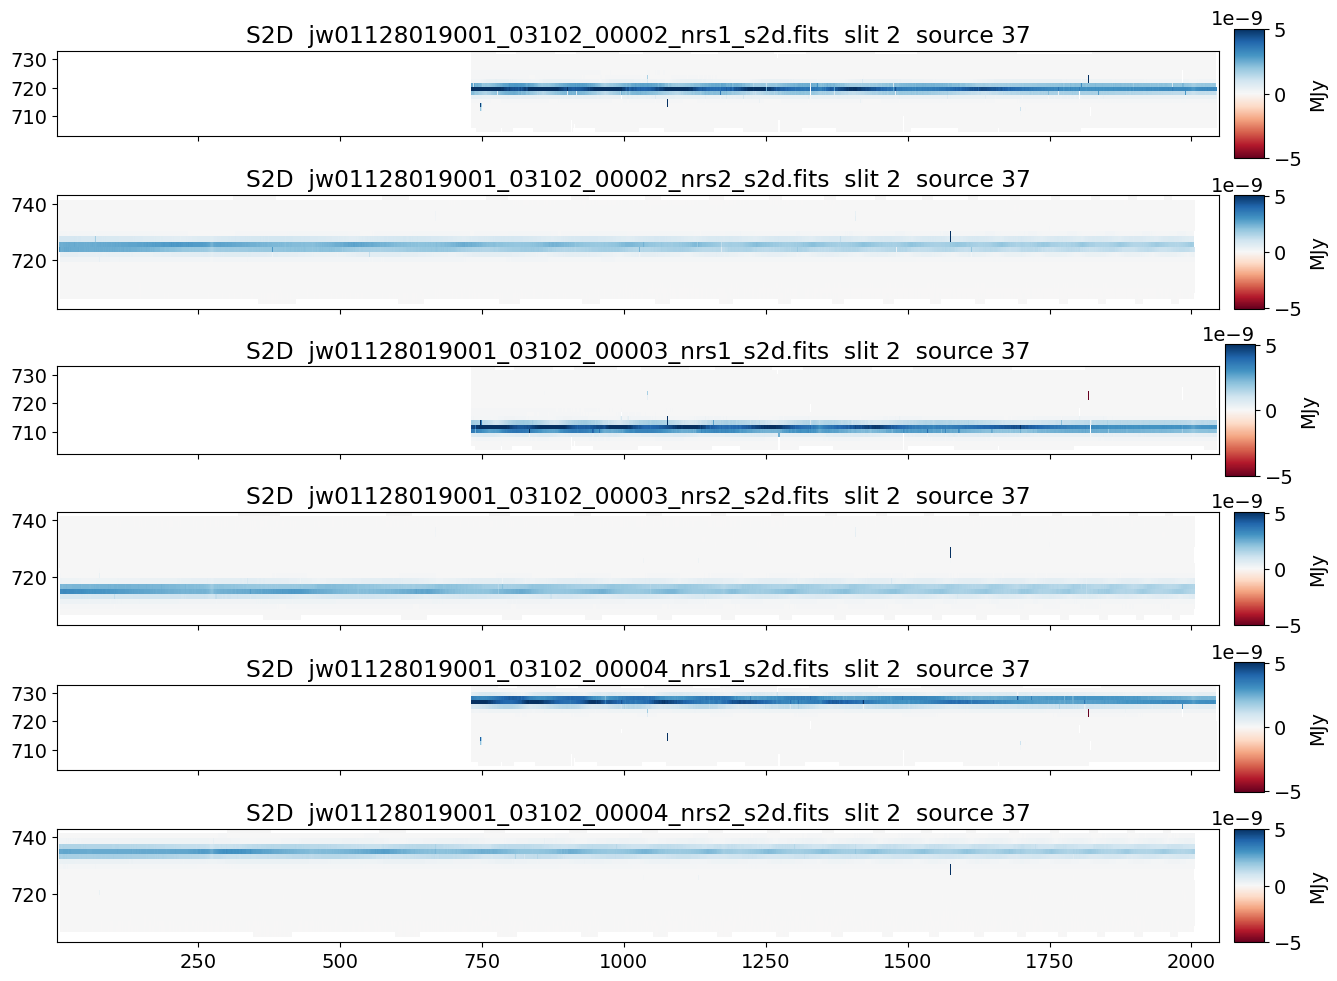

In [59]:
show_MOS_CAL(s2d_spec2_models, source_id=source_id, white_zero=True) #, title_start='MAST S2D')

### Show CAL files

In [60]:
cal_spec2_files = glob(os.path.join(output_dir, '*0000*_cal.fits'))
#cal_spec2_files = glob(os.path.join('no-background-subtraction2', '*0000*_cal.fits'))
cal_spec2_files

['no-background-subtraction/jw01128019001_03102_00003_nrs2_cal.fits',
 'no-background-subtraction/jw01128019001_03102_00004_nrs2_cal.fits',
 'no-background-subtraction/jw01128019001_03102_00002_nrs1_cal.fits',
 'no-background-subtraction/jw01128019001_03102_00004_nrs1_cal.fits',
 'no-background-subtraction/jw01128019001_03102_00003_nrs1_cal.fits',
 'no-background-subtraction/jw01128019001_03102_00002_nrs2_cal.fits']

In [61]:
cal_spec2_models = []
for ical, cal_file in enumerate(sorted(cal_spec2_files)):
    print(ical, cal_file)
    cal_model = datamodels.open(cal_file)
    cal_spec2_models.append(cal_model)

0 no-background-subtraction/jw01128019001_03102_00002_nrs1_cal.fits
1 no-background-subtraction/jw01128019001_03102_00002_nrs2_cal.fits
2 no-background-subtraction/jw01128019001_03102_00003_nrs1_cal.fits
3 no-background-subtraction/jw01128019001_03102_00003_nrs2_cal.fits
4 no-background-subtraction/jw01128019001_03102_00004_nrs1_cal.fits
5 no-background-subtraction/jw01128019001_03102_00004_nrs2_cal.fits


In [62]:
source_id = 37

2024-02-12 16:08:34,969 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


-3.5147187e-11 5.396258e-09


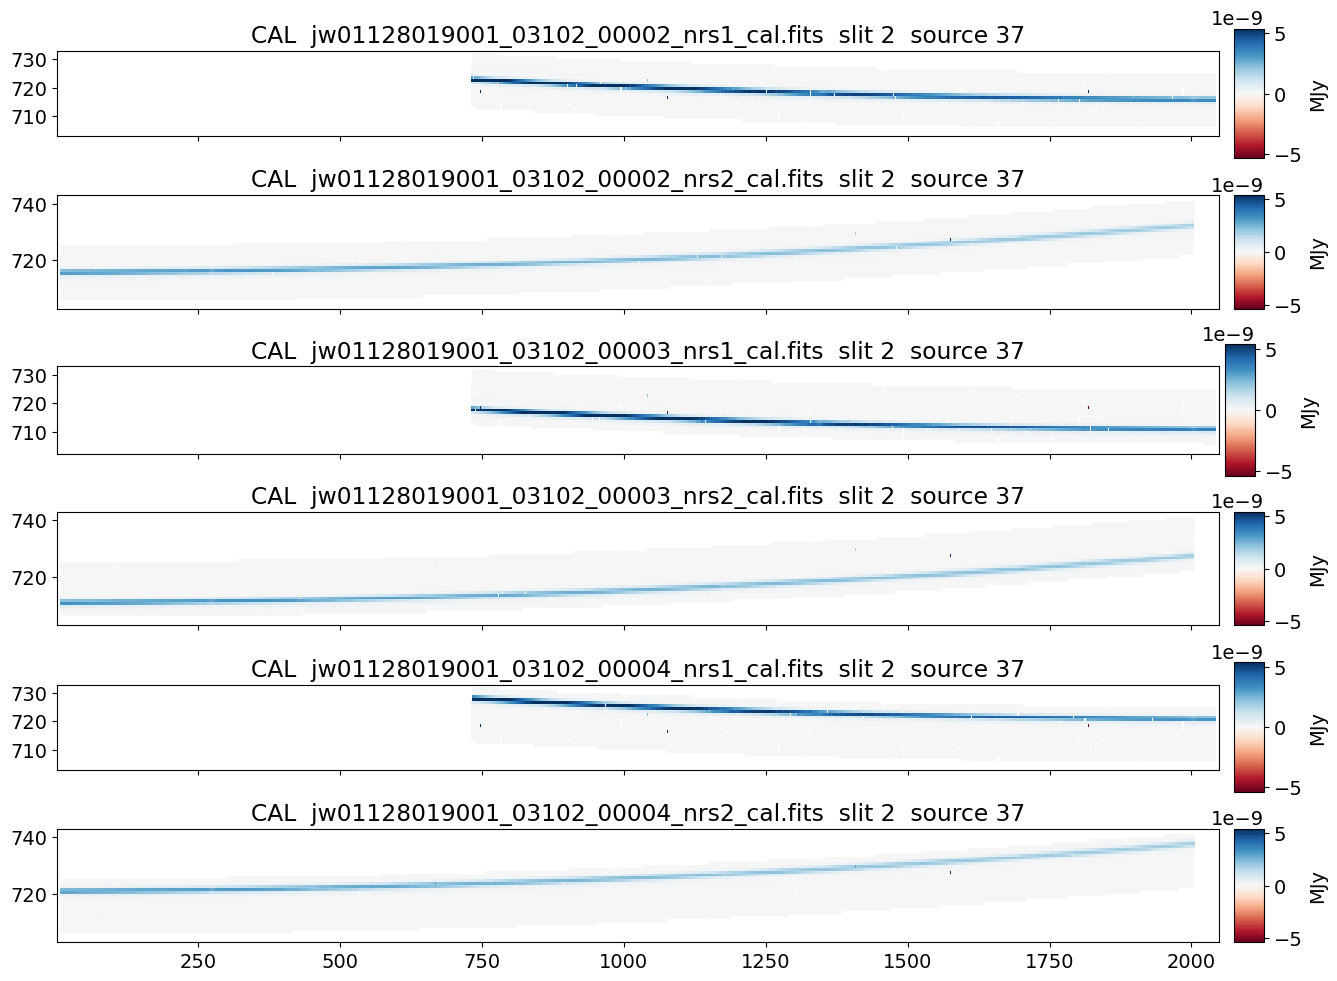

In [63]:
show_MOS_CAL(cal_spec2_models, source_id=source_id, white_zero=True) #, title_start='MAST S2D')

In [ ]:
#output_dir

# Stage 3 `Spec3Pipeline`: combine exposures –> `s2d`, `x1d` for each target <a id='stage3'></a> 

`calwebb_spec3`
[JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec3) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html)

### Create association file

In [67]:
source_ids = set(shutter_table['source_id'])
np.sort(list(source_ids)).tolist()

[37]

In [68]:
source_id = list(source_ids)[0]

In [69]:
cal_files = sorted(glob(os.path.join(output_dir, '*_cal.fits')))
cal_files = [os.path.basename(cal_file) for cal_file in cal_files]
cal_files

['jw01128019001_03102_00002_nrs1_cal.fits',
 'jw01128019001_03102_00002_nrs2_cal.fits',
 'jw01128019001_03102_00003_nrs1_cal.fits',
 'jw01128019001_03102_00003_nrs2_cal.fits',
 'jw01128019001_03102_00004_nrs1_cal.fits',
 'jw01128019001_03102_00004_nrs2_cal.fits']

In [70]:
cal_file = os.path.basename(cal_files[0])
#cal_file

In [71]:
spec3_asn_file = cal_file[:20] + 'spec3_asn.json' % source_id
spec3_asn_file

'jw01128019001_03102_spec3_asn.json'

In [72]:
spec3_file = cal_file[:20] + 'spec3' % source_id
spec3_file

'jw01128019001_03102_spec3'

In [73]:
#from jwst.associations import asn_from_list

In [74]:
asn_data = asn_from_list.asn_from_list(cal_files, product_name=os.path.basename(spec3_file))
asn_data

{
    "asn_type": "None",
    "asn_rule": "DMS_Level3_Base",
    "version_id": null,
    "code_version": "1.13.4",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "target": "none",
    "asn_pool": "none",
    "products": [
        {
            "name": "jw01128019001_03102_spec3",
            "members": [
                {
                    "expname": "jw01128019001_03102_00002_nrs1_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "jw01128019001_03102_00002_nrs2_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "jw01128019001_03102_00003_nrs1_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "jw01128019001_03102_00003_nrs2_cal.fits",
                    "exptype": 

In [75]:
spec3_asn_file = os.path.join(output_dir, os.path.basename(spec3_asn_file))
spec3_asn_file

'no-background-subtraction/jw01128019001_03102_spec3_asn.json'

In [76]:
with open(spec3_asn_file, 'w') as outfile:
    name, serialized = asn_data.dump(format='json')
    outfile.write(serialized)

### Setup `Spec3Pipeline`

In [77]:
spec3pipe = Spec3Pipeline()
#spec3pipe.__dict__.keys()
print_dict(spec3pipe.steps)
#spec3pipe.__dict__  # show all input values

2024-02-12 16:10:08,202 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2024-02-12 16:10:08,204 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2024-02-12 16:10:08,205 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2024-02-12 16:10:08,205 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2024-02-12 16:10:08,207 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2024-02-12 16:10:08,208 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2024-02-12 16:10:08,210 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2024-02-12 16:10:08,211 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2024-02-12 16:10:08,212 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep instance created.
2024-02-12 16:10:08,213 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance

 assign_mtwcs
     output_file : None
     output_dir : None
     output_ext : .fits
     output_use_model : True
     output_use_index : True
     save_results : False
     skip : False
     suffix : assign_mtwcs
     search_output_file : True
     input_dir : None
     class : 
 master_background
     output_file : None
     output_dir : None
     output_ext : .fits
     output_use_model : True
     output_use_index : True
     save_results : False
     skip : False
     suffix : None
     search_output_file : True
     input_dir : None
     user_background : None
     save_background : False
     force_subtract : False
     class : 
 mrs_imatch
     output_file : None
     output_dir : None
     output_ext : .fits
     output_use_model : False
     output_use_index : True
     save_results : False
     skip : False
     suffix : None
     search_output_file : True
     input_dir : None
     bkg_degree : 1
     subtract : False
     class : 
 outlier_detection
     output_file : None

In [78]:
with open(spec3_asn_file) as f_obj:
    asn_data = json.load(f_obj)
    spec2_cal_files = []
    for member in asn_data['products'][0]['members']:
        if member['exptype'] == 'science':
            spec2_cal_file = member['expname']
            spec2_cal_files.append(spec2_cal_file)
            print(spec2_cal_file)

jw01128019001_03102_00002_nrs1_cal.fits
jw01128019001_03102_00002_nrs2_cal.fits
jw01128019001_03102_00003_nrs1_cal.fits
jw01128019001_03102_00003_nrs2_cal.fits
jw01128019001_03102_00004_nrs1_cal.fits
jw01128019001_03102_00004_nrs2_cal.fits


In [79]:
#spec3_output_dir = os.path.join(output_dir, 'spec3')  # Create a subdirectory for the many output files (several for each extracted source)
spec3_output_dir = output_dir
spec3_output_dir  # there's only one source, so not many output files

'no-background-subtraction'

In [80]:
params_spec3 = {}
params_spec3['outlier_detection'] = {'skip' : False} # Flag outlier bad pixels and cosmic rays in DQ array of each input image
params_spec3['resample_spec']     = {'weight_type' : 'exptime'}  # 'ivm' pixel-based inverse read noise vs. 'exptime' single value exposure time
params_spec3['extract_1d']        = {'use_source_posn' : 'True'} # extraction rows based on expected source position
#params_spec3['bkg_subtract']      = {'skip': True}
params_spec3['master_background'] = {'skip': True}
params_spec3

{'outlier_detection': {'skip': False},
 'resample_spec': {'weight_type': 'exptime'},
 'extract_1d': {'use_source_posn': 'True'},
 'master_background': {'skip': True}}

In [81]:
spec3_asn_file

'no-background-subtraction/jw01128019001_03102_spec3_asn.json'

In [82]:
spec3_output_dir

'no-background-subtraction'

### Run `Spec3Pipeline`

In [83]:
if run_pipeline:
    spec3_result = Spec3Pipeline.call(
        spec3_asn_file,
        save_results = True,
        output_dir = spec3_output_dir,
        steps = params_spec3
    )

2024-02-12 16:11:15,002 - CRDS - ERROR -  Error determining best reference for 'pars-outlierdetectionstep'  =    parameter='META.EXPOSURE.TYPE [EXP_TYPE]' value='NRS_MSASPEC' is not in ['NRS_IFU']
2024-02-12 16:11:15,014 - CRDS - ERROR -  Error determining best reference for 'pars-spectralleakstep'  =   Unknown reference type 'pars-spectralleakstep'
2024-02-12 16:11:15,022 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2024-02-12 16:11:15,023 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2024-02-12 16:11:15,024 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2024-02-12 16:11:15,025 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2024-02-12 16:11:15,026 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2024-02-12 16:11:15,028 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2024-02-12 16:11:15,029 - s

## Show spectrum result

2024-02-12 16:20:04,091 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.
2024-02-12 16:20:04,107 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


s2d range: -2.994331005368167e-09 2.994331005368167e-09
13.2 20.2
12.0 19.0


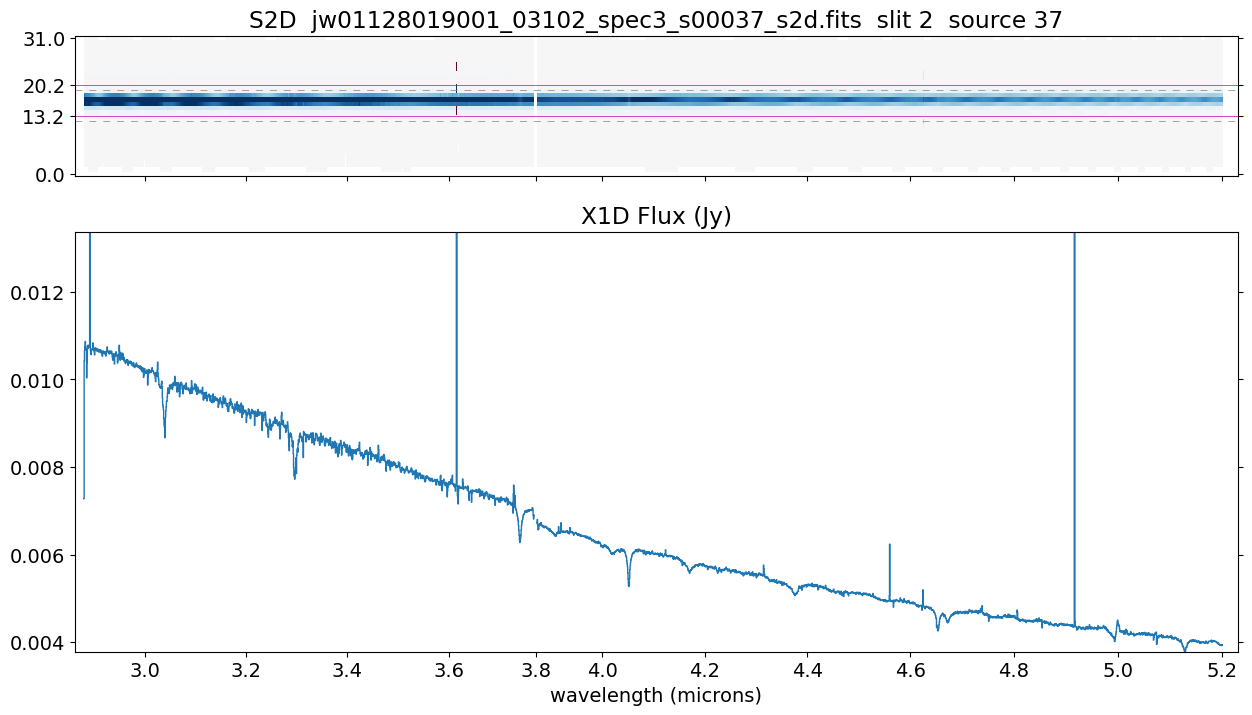

In [95]:
#def show_MOS_spectrum(s2d_model, x1d_model, source_id=None, cmap='viridis', bad_color=(1,0.7,0.7), min_percent=2, max_percent=99.9, ymin=-2e-6, ymax=1e-5):
def show_MOS_spectrum(s2d_model, x1d_model, source_id=None, cmap='RdBu', bad_color='w', white_zero=False,
                     ystart=None, ystop=None): #, bad_color=(0.88,0.88,0.88)):
    # 2D spectrum
    #if source_id:  # s2d has all the objects; extract the one with source_id
    if 'slits' in list(s2d_model):  # s2d has all the objects; extract the one with source_id
        source_ids = [slit.source_id for slit in s2d_model.slits]
        i_slit = source_ids.index(source_id)
        slit_model = s2d_model.slits[i_slit]
    else:  # s2d only has one object
        slit_model = s2d_model
        i_slit = 0
        
    s2d_data = slit_model.data + 0  # load and make copy
    s2d_data = np.where(slit_model.err, s2d_data, np.nan)  # Replace zeros with nan where there is no data

    # 1D spectrum
    x1d_wave    = x1d_model.spec[i_slit].spec_table.WAVELENGTH
    x1d_flux    = x1d_model.spec[i_slit].spec_table.FLUX
    x1d_fluxerr = x1d_model.spec[i_slit].spec_table.FLUX_ERROR
    if np.sum(np.isnan(x1d_fluxerr)) == len(x1d_fluxerr):  # fluxerr all nan?? pipeline bug
        x1d_flux = np.where(x1d_flux, x1d_flux, np.nan)  # Replace zeros with nan where there is no data
    else:
        x1d_flux = np.where(np.isnan(x1d_fluxerr), np.nan, x1d_flux)  # Replace zeros with nan where there is no data
    #x1dflux = np.where(x1dfluxerr, x1dflux, np.nan)  # Replace zeros with nan where there is no data

    wave_min, wave_max = x1d_wave[0], x1d_wave[-1]
    eps = 1e-7
    #major_tick_interval = 0.5
    major_tick_interval = 0.2
    xtick_min = np.ceil((wave_min - eps) / major_tick_interval) * major_tick_interval
    xticks = np.arange(xtick_min, wave_max, major_tick_interval)
    #xticks = np.append(xticks, [5.2])
    num_waves = len(x1d_wave)
    xtick_pos = np.interp(xticks, x1d_wave, np.arange(num_waves))
    xtick_labels = ['%.1f' % xtick for xtick in xticks]
    
    #xtick_labels = [label.replace('4.8', '') for label in xtick_labels]  # remove 4.8
    # Remove any tick labels that are too close and would overlap
    for i in range(len(xtick_pos)-1):
        dx = xtick_pos[i+1] - xtick_pos[i]
        if dx < 40:
            xtick_labels[i] = ''
    
    #for label in xtick_labels: print(label, ' ', end='')

    # Make Figure
    fig, (ax2d, ax1d) = plt.subplots(2, 1, figsize=(15,8), height_ratios=[1,3], squeeze=True, sharex=True)
    cmap = matplotlib.colormaps[cmap]
    cmap.set_bad(bad_color, 1.)

    sigma_clipped_data = sigma_clip(s2d_data, sigma=5, maxiters=3)
    ymin = np.min(sigma_clipped_data)
    #ymin = 0.2 * ymin
    ymax = np.max(sigma_clipped_data)
    if white_zero:
        ymin = -ymax  # center range about zero; but there may be some bias positive or negative

    #ymax = 2 * np.nanpercentile(s2d_data, 90)
    #ymin = -0.2 * ymax
    
    # plot the rectified 2D spectrum
    #norm = simple_norm(s2dsci, 'linear', min_percent=2, max_percent=99.9)
    #norm = simple_norm(s2d_data, 'asinh', min_percent=min_percent, max_percent=max_percent)
    norm = simple_norm(s2d_data, 'linear', min_cut=ymin, max_cut=ymax)
    print('s2d range:', norm.vmin, norm.vmax)
    im = ax2d.imshow(s2d_data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')
    num_cross, num_dispersion = s2d_data.shape
    width_1d = 3
    ny, nx = s2d_data.shape
    ax2d.yaxis.set_ticks_position('both')
    #ax2d.axhline((ny-1)/2., c='w', lw=0.5, alpha=0.5, ls='--')
    if ystart:
        for y in ystart, ystop:
            #ax2d.axhline(y, c='w', lw=0.5, alpha=0.5, ls='--')
            ax2d.axhline(y, c='m', lw=0.5)
        ax2d.set_yticks([0, ystart, ystop, ny-1])
        print(ystart, ystop)
        if 1:
            extract_width = 8
            ystart0 = ny//2 - extract_width/2
            ystop0  = ny//2 + extract_width/2 -1
            print(ystart0, ystop0)
            for y in ystart0, ystop0:
                ax2d.axhline(y, c='0.50', lw=0.5, ls='--', dashes=(10,10))
    else:
        ax2d.set_yticks([0, (ny-1)/2., ny-1])
    
    # plot the 1D extraction  x1d vs. indices, same as s2d array above
    ax1d.axhline(0, c='0.50', lw=0.5, alpha=0.66, ls='-')
    ax1d.step(np.arange(num_waves), x1d_fluxerr, lw=0.5, c='r', alpha=0.66)
    ax1d.step(np.arange(num_waves), x1d_flux, lw=1)
    ax1d.set_xlim(0, num_waves)
    ax1d.yaxis.set_ticks_position('both')

    sigma_clipped_data = sigma_clip(x1d_flux, sigma=5, maxiters=3)
    ymin = np.min(sigma_clipped_data)
    ymax = np.max(sigma_clipped_data)
    #ax1d.set_ylim(-2e-6, 2e-5)
    ax1d.set_ylim(ymin, ymax)
    
    title = 'S2D  ' + os.path.basename(s2d_model.meta.filename) 
    title += '  slit %d'   % slit_model.slitlet_id
    title += '  source %d' % slit_model.source_id
    ax2d.set_title(title)
    ax1d.set_title('X1D Flux (Jy)')
    plt.xticks(xtick_pos, xtick_labels)
    plt.xlabel('wavelength (microns)');

show_MOS_spectrum(s2d_model, x1d_model, source_id, white_zero=True, ystart=13.2, ystop=20.2)

In [85]:
s2d_spec3_files = glob(os.path.join(output_dir, '*_spec3_*_s2d.fits'))
#s2d_spec3_files
s2d_file = s2d_spec3_files[0]
s2d_file

'no-background-subtraction/jw01128019001_03102_spec3_s00037_s2d.fits'

In [86]:
#s2d_file = 'jw01128019001_03102_spec3_asn_s2d.fits'
#s2d_file = os.path.join(output_dir, s2d_file)
s2d_model = datamodels.open(s2d_file)
s2d_file

'no-background-subtraction/jw01128019001_03102_spec3_s00037_s2d.fits'

In [87]:
x1d_file = s2d_file.replace('s2d', 'x1d')
print(x1d_file)
x1d_model = datamodels.open(x1d_file)
#x1d_model.info(max_rows=99999)  # show all contents

no-background-subtraction/jw01128019001_03102_spec3_s00037_x1d.fits


2024-02-12 16:13:58,310 - stpipe - WARNING - Input data contains invalid values (NaNs or infs), which were automatically clipped.


s2d range: -2.994331005368167e-09 2.994331005368167e-09


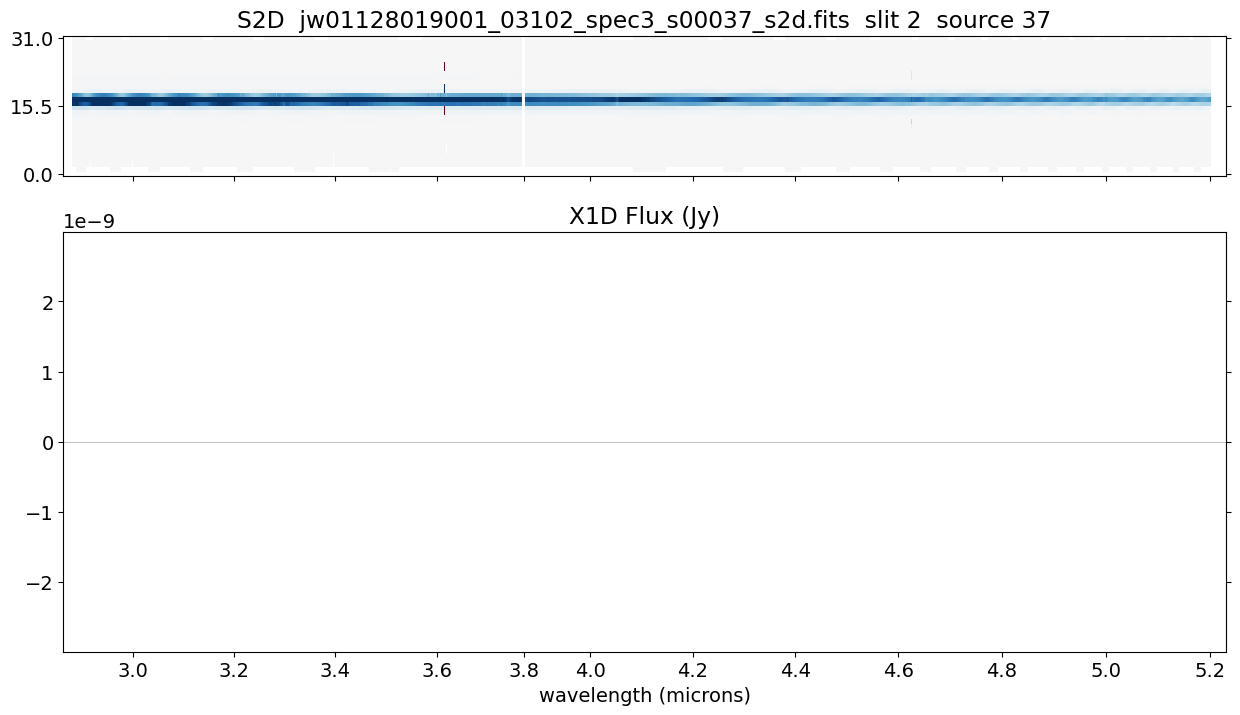

In [90]:
show_MOS_spectrum(s2d_model, x1d_model, source_id, white_zero=True)

# `Extract1dStep`: Adjust 2D –> 1D extraction

[extract1d](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d) • 
[Extract1dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_1d.Extract1dStep.html) • 
[Description](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/description.html#extraction-for-2d-slit-data) • 
[Editing JSON reference file](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html#editing-json-reference-file-format-for-non-ifu-data)

OPTIONAL to modify which rows in S2D (2D spectrum) are used for extraction to X1D (1D spectrum). 
Useful for source off-center in slit in the cross-dispersion direction.

(Note the X1D file does not save information about which rows were used. This information is printed as output during execution but not saved.)

Define extraction region in `.json` file, then run `Extract1dStep`  
Output file will end in `_extract1dstep.fits`

`extract_width` takes priority over `ystart` and `ystop` for the extraction width,   
but `ystart` and `ystop` will still be used to define the centering of the extraction region in the cross-dispersion direction.

All of these values are zero-indexed integers. The start and stop limits are inclusive.

The default EXTRACT1D reference file is found in CRDS. The user can download this file from https://jwst-crds.stsci.edu, modify the contents, and then use this modified file in `Extract1dStep` by specifying this modified reference file with the `override_extract1d` option


### See also

* [Adjusting the extraction region](https://github.com/spacetelescope/jwst-caveat-examples/blob/main/NIRSPEC_General/nrs_recenter_extraction_workaround.ipynb)
* [MOSViz interactive extraction](https://spacetelescope.github.io/jdat_notebooks/notebooks/mos_spectroscopy_advanced/MOSspec_advanced.html)
* [Optimal extraction](https://spacetelescope.github.io/jdat_notebooks/notebooks/optimal_extraction/Spectral_Extraction-static.html)
* [msaexp optimal extraction](https://github.com/gbrammer/msaexp/blob/d7368560cf465a0828e942454cfcc0bbe6870278/msaexp/drizzle.py#L869C19-L869C19)


### Either download the default `extract1d` parameter reference file from CRDS...

In [ ]:
#default_extract1d_json_file = 'jwst_nirspec_extract1d_0003.json'  # could find this on https://jwst-crds.stsci.edu

In [ ]:
s2d_header = fits.open(s2d_file)[0].header
s2d_file

In [ ]:
crds_context = crds.get_default_context()
crds_context

In [ ]:
# Download the reference file, or find it in your cache
default_extract1d_json_file = crds.getreferences(s2d_header, reftypes=['extract1d'], context=crds_context, observatory='jwst')['extract1d']
default_extract1d_json_file

In [ ]:
with open(default_extract1d_json_file) as f_obj:
    extract1d_json_data = json.load(f_obj)

In [ ]:
#extract1d_json_data
JSON(extract1d_json_data, expanded=True)

### ...or create the JSON file from scratch

In [ ]:
extract1d_json_data = {'reftype':'EXTRACT1D', 'instrument':'NIRSPEC', 'telescope':'JWST', 'exp_type':'NRS_MSASPEC'}
extract1d_json_data['apertures'] = [{'id':'ANY', 'region_type':'target', 'independent_var':'pixel', 'bkg_order':0, 'dispaxis':1,
                                   'extract_width':8,  # Best not to adjust this. Slit losses are calibrated to this extraction width.
                                   }]

if run_pipeline:
    json_object = json.dumps(extract1d_json_data, indent=4)
    default_extract1d_json_file = 'jwst_nirspec_extract1d_default.json'
    with open(default_extract1d_json_file, "w") as outfile:
        outfile.write(json_object)
    
    JSON(extract1d_json_data, expanded=True)

### Define the extraction region

In [ ]:
#ystart = 21  # You decide which rows to use for the extraction region
#ycenter = 15  # for most sources with standard 3-slitlet nods
ycenter = 25
extract_width = extract1d_json_data['apertures'][0]['extract_width']  # use default extraction width
ystart = ycenter - extract_width // 2
ystop = ystart + extract_width - 1
extract1d_json_data['apertures'][0]['ystart'] = ystart
extract1d_json_data['apertures'][0]['ystop']  = ystop
print(ystart, ystop)

In [ ]:
extract1d_json_data['apertures'][0]

In [ ]:
if run_pipeline:
    json_object = json.dumps(extract1d_json_data, indent=4)
    custom_extract1d_json_file = 'jwst_nirspec_extract1d_custom.json'
    with open(custom_extract1d_json_file, "w") as outfile:
        outfile.write(json_object)

In [ ]:
if run_pipeline:
    extract1d_result = Extract1dStep.call(s2d_file,
                                use_source_posn=False, 
                                apply_apcorr=False,
                                override_extract1d = custom_extract1d_json_file,
                                save_results=True, output_dir=spec3_output_dir)

# Output file ends in _extract1dstep (not _x1d); okay to save in same output directory
# jw02736-o007_s06355_nirspec_f290lp-g395m_extract1dstep.fits

In [ ]:
extract_x1d_file = s2d_file.replace('s2d', 'extract1dstep')
print(extract_x1d_file)
extract1d_result = datamodels.open(extract_x1d_file)

### Show the result

In [ ]:
#show_MOS_spectrum(s2d_model, x1d_model, source_id)
show_MOS_spectrum(s2d_model, extract1d_result, ystart=ystart, ystop=ystop)

### Compare spectra from MAST, pipeline reprocessing, and updated 1D extraction

In [ ]:
s2d_file

In [ ]:
x1d_file = s2d_file.replace('s2d', 'x1d')
s2d_model = datamodels.open(s2d_file)
x1d_model = datamodels.open(x1d_file)
x1d_wave = x1d_model.spec[0].spec_table.WAVELENGTH
x1d_flux = x1d_model.spec[0].spec_table.FLUX

In [ ]:
extract1d_file = s2d_file.replace('s2d', 'extract1dstep')
extract1d_model = datamodels.open(extract1d_file)
extract1d_wave = extract1d_model.spec[0].spec_table.WAVELENGTH
extract1d_flux = extract1d_model.spec[0].spec_table.FLUX

In [ ]:
MAST_s2d_file = download_jwst_files([s2d_file], download_dir)[0]
MAST_x1d_file = download_jwst_files([x1d_file], download_dir)[0]
MAST_s2d_model = datamodels.open(MAST_s2d_file)
MAST_x1d_model = datamodels.open(MAST_x1d_file)
x1d_wave_MAST = MAST_x1d_model.spec[0].spec_table.WAVELENGTH
x1d_flux_MAST = MAST_x1d_model.spec[0].spec_table.FLUX

In [ ]:
num_waves = len(x1d_wave)
wave_min, wave_max = x1d_wave[0], x1d_wave[-1]
eps = 1e-7
#major_tick_interval = 0.5
major_tick_interval = 0.2
xtick_min = np.ceil((wave_min - eps) / major_tick_interval) * major_tick_interval
xticks = np.arange(xtick_min, wave_max, major_tick_interval)
#xticks = np.append(xticks, [5.2])
num_waves = len(x1d_wave)
xtick_pos = np.interp(xticks, x1d_wave, np.arange(num_waves))
xtick_labels = ['%.1f' % xtick for xtick in xticks]

### Compare MAST (default pipeline) vs. pipeline reprocessing

In [ ]:
fig, (ax2d, ax1d) = plt.subplots(2, 1, figsize=(15,8), height_ratios=[1,3], squeeze=True, sharex=True)

# plot the rectified 2D spectrum
#norm = simple_norm(s2dsci, 'linear', min_percent=10, max_percent=99.9)
s2d_data = np.where(s2d_model.err, s2d_model.data, np.nan)  # Replace zeros with nan where there is no data
norm = simple_norm(s2d_data, 'asinh', min_percent=2, max_percent=99.95)
cmap = matplotlib.colormaps['viridis']
cmap.set_bad((1,0.8,0.8), 1.)
im = ax2d.imshow(s2d_data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')

ax1d.step(np.arange(num_waves), x1d_flux_MAST,  lw=1, c='c', label='MAST')
ax1d.step(np.arange(num_waves), x1d_flux,       lw=1, c='k', label='reprocessed', alpha=0.7)
#xlim = ax1d.get_xlim()
ax1d.set_xlim(0, num_waves)
ax1d.set_title('X1D Flux (Jy)')

plt.xticks(xtick_pos, xtick_labels)
plt.xlabel('wavelength (microns)')
plt.legend();

### Compare updated 1D extraction

In [ ]:
fig, (ax2d, ax1d) = plt.subplots(2, 1, figsize=(15,8), height_ratios=[1,3], squeeze=True, sharex=True)

# plot the rectified 2D spectrum
#norm = simple_norm(s2dsci, 'linear', min_percent=10, max_percent=99.9)
s2d_data = np.where(s2d_model.err, s2d_model.data, np.nan)  # Replace zeros with nan where there is no data
norm = simple_norm(s2d_data, 'asinh', min_percent=2, max_percent=99.95)
cmap = matplotlib.colormaps['viridis']
cmap.set_bad((1,0.8,0.8), 1.)
im = ax2d.imshow(s2d_data, origin='lower', cmap=cmap, aspect='auto', norm=norm, interpolation='nearest')

ax1d.step(np.arange(num_waves), x1d_flux_MAST,  lw=1, c='c', label='MAST',  alpha=0.5)
ax1d.step(np.arange(num_waves), x1d_flux,       lw=1, c='k', label='reprocessed',  alpha=0.5)
ax1d.step(np.arange(num_waves), extract1d_flux, lw=1, c='r', label='re-extracted', alpha=1)
#xlim = ax1d.get_xlim()
ax1d.set_xlim(0, num_waves)
ax1d.set_title('X1D Flux (Jy)')

ax2d.set_yticks([ystart, ystop])
for y in ystart, ystop:
    ax2d.axhline(y, c='r', alpha=1, lw=1, ls='-')

plt.xticks(xtick_pos, xtick_labels)
plt.xlabel('wavelength (microns)')
plt.legend();

# Authors

Dan Coe (dcoe@stsci.edu) including many contributions from others on the NIRSpec team, including Elena Manjavacas, Peter Zeidler, Kayli Glidic, Melanie Clarke, James Muzerrole, Nikolay Nikolov, and Alaina Henry who designed the ERO NIRSpec observations